# Cats and Dogs


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os
import sys
import time
import copy
import numpy as np
import numpy.random as nr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms, models

print('GPU available:', torch.cuda.is_available())

GPU available: True


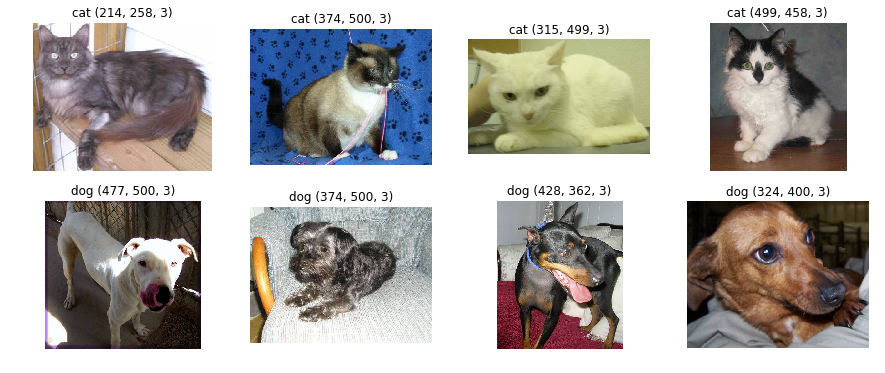

In [22]:
train_data_dir = '../../datasets/CatsDogs/train/'
valid_data_dir = '../../datasets/CatsDogs/validation/'

nb_train_samples = 2000
nb_valid_samples = 800

fig = plt.figure(figsize=(15,6))
for i, j in enumerate(nr.randint(0, 1000, 4)):
    fig.add_subplot(2,4, i+1)
    img = plt.imread('{}/cats/cat.{}.jpg'.format(train_data_dir, j))
    plt.imshow(img)
    plt.title('cat {}'.format(img.shape))
    plt.axis('off')
    
    fig.add_subplot(2,4, i+5)
    img = plt.imread('{}/dogs/dog.{}.jpg'.format(train_data_dir, j))
    plt.imshow(img)
    plt.title('dog {}'.format(img.shape))
    plt.axis('off')


In [37]:
batch_size = 20
img_width, img_height = 224, 224

def my_transforms(img):
    return img.resize((img_width, img_height))

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}

dsets = {
    'train': datasets.ImageFolder(train_data_dir, data_transforms['train']),
    'valid': datasets.ImageFolder(valid_data_dir, data_transforms['valid'])
}

dset_loaders = {
    'train': torch.utils.data.DataLoader(dsets['train'], batch_size=batch_size, shuffle=True),
    'valid': torch.utils.data.DataLoader(dsets['valid'], batch_size=batch_size, shuffle=True)
}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

torch.Size([3, 224, 224]) torch.Size([20])


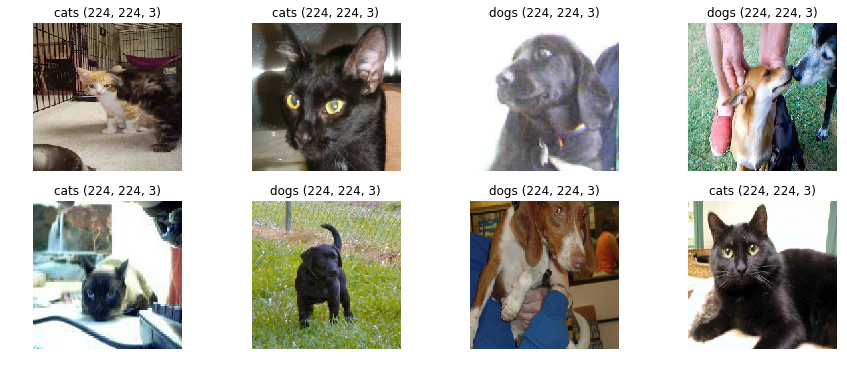

In [38]:
# Get a batch of training data
inputs, cls = next(iter(dset_loaders['train']))

print(inputs[8].shape, cls.shape)

fig = plt.figure(figsize=(15,6))
for i, j in enumerate(range(4)):
    fig.add_subplot(2,4, i+1)
    img = denormalize(inputs.numpy()[j])
    plt.imshow(img)
    plt.title('{} {}'.format(dset_classes[cls[j]], img.shape))
    plt.axis('off')
    
for i, j in enumerate(range(4, 8)):
    fig.add_subplot(2,4, i+5)
    img = denormalize(inputs.numpy()[j])
    plt.imshow(img)
    plt.title('{} {}'.format(dset_classes[cls[j]], img.shape))
    plt.axis('off')


In [5]:
model_name = '../../models/cats-dogs-pytorch.model'

def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25, model_fn=model_name):
    since = time.time()

    if os.path.isfile(model_fn):
        model.load_state_dict(torch.load(model_fn))
    
    best_model = model
    best_acc = 0.0
    best_epoch = 0
    
    losses = dict(train=[], valid=[])

    try:
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    optimizer = lr_scheduler(optimizer, epoch)
                    model.train(True)  # Set model to training mode
                else:
                    model.train(False)  # Set model to evaluate mode

                t0 = time.time()

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for data in dset_loaders[phase]:
                    # get the inputs
                    inputs, labels = data

                    # wrap them in Variable
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss += loss.data[0]
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dset_sizes[phase]
                epoch_acc = running_corrects / dset_sizes[phase]
                
                losses[phase].append((epoch_loss, epoch_acc))

                t1 = time.time()
                print('{} Loss: {:.4f} Acc: {:.4f}   {:.4f} min'.format(phase, epoch_loss, epoch_acc, (t1-t0)/60))

                # deep copy the model
                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_epoch = epoch
                    best_model = copy.deepcopy(model)

            print()
    
    except KeyboardInterrupt:
        print('\nInterrupted!\n')
    
    finally:
        torch.save(best_model.state_dict(), model_fn)

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}min {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}  on epoch {}'.format(best_acc, best_epoch))
        
    return best_model, losses


In [6]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [41]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = denormalize(inp.numpy())
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plts are updated

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    for i, data in enumerate(dset_loaders['valid']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        fig = plt.figure(figsize=(15, 10))
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//3, 3, images_so_far)
            ax.axis('off')
            ax.set_title('pred/lab: {} / {}'.format(dset_classes[preds[j]], dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [8]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


In [9]:
try:
    model_conv, losses = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)
except KeyboardInterrupt:
    pass


Epoch 0/9
----------
LR is set to 0.001
train Loss: 0.0136 Acc: 0.8840   0.3106 min
valid Loss: 0.0126 Acc: 0.8825   0.1029 min

Epoch 1/9
----------
train Loss: 0.0082 Acc: 0.9355   0.2670 min
valid Loss: 0.0046 Acc: 0.9700   0.0994 min

Epoch 2/9
----------
train Loss: 0.0058 Acc: 0.9580   0.2589 min
valid Loss: 0.0041 Acc: 0.9725   0.0990 min

Epoch 3/9
----------
train Loss: 0.0061 Acc: 0.9500   0.2591 min
valid Loss: 0.0037 Acc: 0.9762   0.0991 min

Epoch 4/9
----------
train Loss: 0.0059 Acc: 0.9535   0.2589 min
valid Loss: 0.0039 Acc: 0.9738   0.0990 min

Epoch 5/9
----------
train Loss: 0.0051 Acc: 0.9575   0.2593 min
valid Loss: 0.0035 Acc: 0.9750   0.0970 min

Epoch 6/9
----------
train Loss: 0.0052 Acc: 0.9590   0.2530 min
valid Loss: 0.0036 Acc: 0.9762   0.0968 min

Epoch 7/9
----------
LR is set to 0.0001
train Loss: 0.0047 Acc: 0.9630   0.2501 min
valid Loss: 0.0035 Acc: 0.9775   0.0954 min

Epoch 8/9
----------
train Loss: 0.0045 Acc: 0.9650   0.2492 min
valid Loss: 0.00

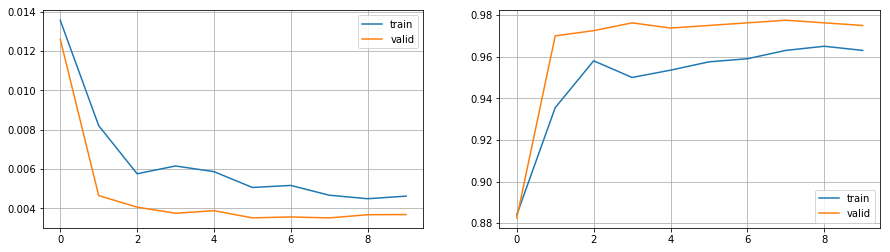

In [20]:
fig = plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
tlos = [l for l, a in losses['train']]
vlos = [l for l, a in losses['valid']]
plt.plot(tlos, label='train')
plt.plot(vlos, label='valid')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
tacc = [a for l, a in losses['train']]
vacc = [a for l, a in losses['valid']]
plt.plot(tacc, label='train')
plt.plot(vacc, label='valid')
plt.legend()
plt.grid()


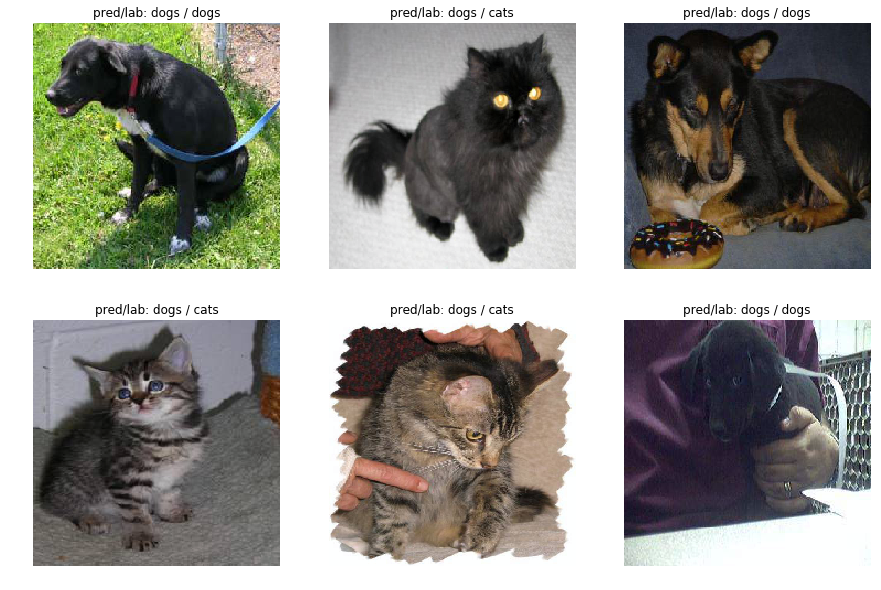

In [42]:
visualize_model(model_conv)